In [1]:
# Install necessary libraries
!pip install open3d numpy tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7

In [2]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 1. Load point cloud data
import open3d as o3d
import numpy as np

def load_point_cloud(file_path):
    point_cloud = o3d.io.read_point_cloud(file_path)
    points = np.asarray(point_cloud.points)
    return points

def normalize_points(points):
    min_vals = np.min(points, axis=0)
    max_vals = np.max(points, axis=0)
    normalized_points = (points - min_vals) / (max_vals - min_vals)
    return normalized_points

# Load and normalize the point cloud
point_cloud_file = "/content/drive/MyDrive/training_point_cloud.ply"
points = load_point_cloud(point_cloud_file)
normalized_points = normalize_points(points)
print(f"Loaded point cloud with {points.shape[0]} points.")

Loaded point cloud with 12400 points.


In [4]:
# 2. Preprocess point cloud data
def preprocess_points(points, num_features=3, pillar_size=3):
    num_points = points.shape[0]
    reshaped_points = points[:num_points - (num_points % pillar_size)].reshape((-1, num_features, pillar_size))
    return reshaped_points

reshaped_points = preprocess_points(normalized_points)
print(f"Reshaped points shape: {reshaped_points.shape}")

Reshaped points shape: (4133, 3, 3)


In [5]:
# 3. Load and preprocess labels
def load_labels(file_path):
    """
    Load labels from a text file, skipping any header lines.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    labels = np.array([int(line.strip()) for line in lines if not line.startswith("#")])
    return labels

# Load the labels
labels_file_path = "/content/drive/MyDrive/training_labels.txt"
labels = load_labels(labels_file_path)
print(f"Loaded {len(labels)} labels.")

# Ensure the labels match the preprocessed points
reshaped_labels = labels[:reshaped_points.shape[0]]

# Convert labels to one-hot encoding
import tensorflow as tf
num_classes = len(np.unique(labels))
one_hot_labels = tf.keras.utils.to_categorical(reshaped_labels, num_classes=num_classes)
print(f"One-hot encoded labels shape: {one_hot_labels.shape}")

Loaded 12400 labels.
One-hot encoded labels shape: (4133, 6)


In [6]:
# 4. Build CenterPoint model
def build_centerpoint_model(input_shape=(3, 3)):
    """
    Build a simple Center-based 3D Object Detection model using dense layers.
    """
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs, name="CenterPoint")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

input_shape = reshaped_points.shape[1:]
centerpoint_model = build_centerpoint_model(input_shape)
centerpoint_model.summary()


Model: "CenterPoint"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3, 3)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,102 (172.27 KB)

 Trainable params: 44,102 (172.27 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 5. Train the model
history = centerpoint_model.fit(
    reshaped_points,
    one_hot_labels,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7655 - loss: 0.7883 - val_accuracy: 0.0351 - val_loss: 1.2274
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8976 - loss: 0.1545 - val_accuracy: 0.0000e+00 - val_loss: 1.5717
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9056 - loss: 0.1372 - val_accuracy: 0.1499 - val_loss: 0.9996
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9135 - loss: 0.1354 - val_accuracy: 0.0000e+00 - val_loss: 1.4048
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9070 - loss: 0.1397 - val_accuracy: 0.0060 - val_loss: 1.3246
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9091 - loss: 0.1320 - val_accuracy: 0.0000e+00 - val_loss: 1.6312
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9068 - loss: 0.1364 - val_accuracy: 0.0085 - val_loss: 1.3333
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9059 - loss: 0.125

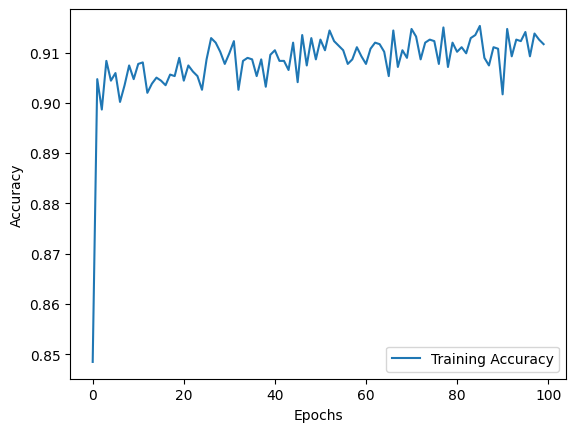

In [8]:
# 6. Plot training accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
# 7. Visualize detected objects
def summarize_detected_objects(points, predictions):
    """
    Summarize detected objects and their counts.
    """
    predicted_classes = np.argmax(predictions, axis=1)
    object_points = points[predicted_classes != 0]  # Assuming class 0 is "non-object"
    non_object_points = points[predicted_classes == 0]

    print(f"Total Points: {points.shape[0]}")
    print(f"Points identified as objects: {object_points.shape[0]}")
    print(f"Points identified as non-objects: {non_object_points.shape[0]}")

    # Categorize detected objects
    object_classes = {1: "Tree", 2: "Building", 3: "Car", 4: "Person"}  # Example mapping
    unique, counts = np.unique(predicted_classes, return_counts=True)
    print("\nDetected Object Summary:")
    for cls, count in zip(unique, counts):
        obj_name = object_classes.get(cls, f"Unknown (Class {cls})")
        print(f"  - {obj_name}: {count} points")

# Predict and summarize detected objects
predictions = centerpoint_model.predict(reshaped_points)
summarize_detected_objects(normalized_points[:reshaped_points.shape[0]], predictions)

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Total Points: 4133
Points identified as objects: 4133
Points identified as non-objects: 0

Detected Object Summary:
  - Tree: 1000 points
  - Building: 2812 points
  - Car: 321 points


In [10]:
# Save CenterPoint model
save_path = "/content/drive/MyDrive/CenterPoint_Detection.h5"
centerpoint_model.save(save_path)
print(f"CenterPoint model saved to {save_path}")

CenterPoint model saved to /content/drive/MyDrive/CenterPoint_Detection.h5
